In [196]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from math import ceil

In [197]:
# from qiskit import Aer, QuantumCircuit, transpile, assemble
# from qiskit.visualization import plot_histogram

# def initialize_s(qc, qubits):
#     """Apply a Hadamard gate to all qubits in the list."""
#     for q in qubits:
#         qc.h(q)

# def oracle(qc, target_qubit): #bad 
#     """Apply a phase oracle to the target qubit."""
#     qc.z(target_qubit)

# def diffusion(qc, qubits):
#     """Apply the diffusion operator to the qubits."""
#     # Apply Hadamard gates
#     qc.h(qubits)
#     # Apply X gates
#     qc.x(qubits)
#     # Apply controlled-Z gate
#     qc.h(qubits[-1])
#     qc.mct(qubits[:-1], qubits[-1])
#     # Apply X gates
#     qc.x(qubits)
#     # Apply Hadamard gates
#     qc.h(qubits)

# def grovers_algorithm(n, marked_items):
#     # Create a quantum circuit with n qubits and n classical bits
#     qc = QuantumCircuit(n, n)
    
#     # Initialize the superposition of all states
#     initialize_s(qc, range(n))
    
#     # Define the number of Grover iterations (adjust as needed)
#     num_iterations = int(0.5 * (2 ** (n / 2)))
    
#     # Apply Grover iterations
#     for _ in range(num_iterations):
#         # Apply the oracle to mark the solution(s)
#         oracle(qc, marked_items)
        
#         # Apply the diffusion operator
#         diffusion(qc, range(n))
    
#     # Measure the qubits
#     qc.measure(range(n), range(n))
    
#     # Simulate the quantum circuit
#     simulator = Aer.get_backend('qasm_simulator')
#     compiled_circuit = transpile(qc, simulator)
#     result = simulator.run(compiled_circuit).result()
    
#     # Get and plot the result
#     counts = result.get_counts(qc)
#     plot_histogram(counts)

# # Example usage
# n_qubits = 3  # Number of qubits
# marked_items = [4]  # Indices of marked items

# grovers_algorithm(n_qubits, marked_items)

In [198]:
def prepareGroverBlackBox(qubits: int, markedNumber: int): # qubits+1
    qc = QuantumCircuit(qubits)#, name="Grover's Black Box")
    if 2**(qubits-1)-1 < markedNumber:
        raise Exception('markedNumber is too Big')
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(2**(qubits-1)):
        binaryNumber = bin(i+1)[2:].rjust(qubits-1, '0')
        if i+1 == markedNumber:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
        else:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
    qc.unitary(matrix, range(qubits))
    print (qc.to_gate())
    return qc.to_gate()

def inversionAboutMean(qubits: int):
    matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
    qc = QuantumCircuit(qubits, name="Inversion About Mean")
    qc.unitary(matrix, range(qubits))
    return qc.to_gate()
    
def grover(qubits: int, markedNumber:int):
    qc = QuantumCircuit(qubits+1, qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(range(qubits+1))
    numIterations = ceil(np.sqrt(2**qubits))
    print (numIterations)
    for _ in range(numIterations):
        matrix = np.zeros((2**(qubits+1), 2**(qubits+1)))
        for i in range(2**(qubits)):
            binaryNumber = bin(i)[2:].rjust(qubits, '0')
            if i == markedNumber:
                matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
                matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
            else:
                matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
                matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
        qc.unitary(matrix, range(qubits,-1,-1))
        matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
        qc.unitary(matrix, range(qubits-1,-1,-1)) 
        # qc.append(prepareGroverBlackBox(qubits+1, markedNumber), range(qubits,-1,-1))
        # qc.append(inversionAboutMean(qubits), range(qubits-1,-1,-1))
    qc.measure(range(qubits), range(qubits))
    return qc

3
{'101': 84, '011': 100, '111': 87, '100': 100, '001': 101, '110': 98, '000': 94, '010': 360}
010


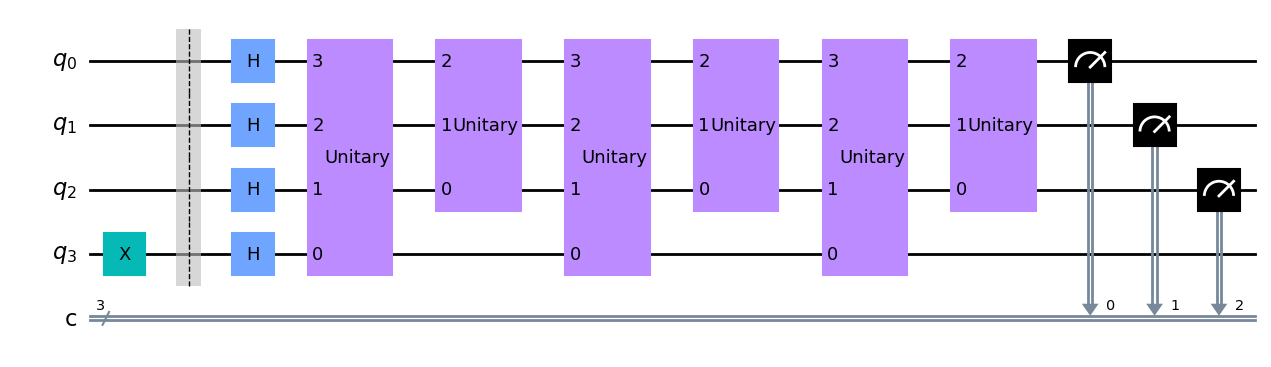

In [213]:
len = 3
number = 2

qc = grover(len, number)

backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
print(result.get_counts())
counts = dict(result.get_counts())
max = 0
for key, value in counts.items():
    if value > max:
        max = value
        maxKey = key

print (maxKey[::-1])
qc.draw('mpl')